In [1]:
import torch
from qadence import feature_map, hea, chain, add, kron
from qadence import QNN, QuantumCircuit, Z, ising_hamiltonian, total_magnetization, hamiltonian_factory
from qadence.types import BasisSet, ReuploadScaling
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from tqdm import tqdm

INFO  2025-01-12 16:15:15 - pyqtorch: PyQTorch logger successfully setup with log level 20


Some stuff might fail: issue in joblib


In [2]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """Compute a derivative of model that learns f(x), computes df/dx using torch.autograd."""
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(outputs),
        create_graph = True,
        retain_graph = True,
    )[0]
    return grad

In [3]:
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor, length_1d, rng) -> torch.Tensor:
    """Loss function encoding the problem to solve."""
    
    #1 Equation loss
    # sample inner domain 
    sample_idxs = rng.integers(0,10000, 100)
    dom_inner_sample = inputs[sample_idxs]
    inner_output = model(dom_inner_sample)
    deriv_model = calc_deriv(calc_deriv(inner_output, inputs), inputs)
    deriv_exact = torch.zeros_like(deriv_model)
    pde_loss = criterion(deriv_model, deriv_exact)

    #2 Boundary loss
    # extract boundaries of domain 
    reshaped_input = inputs.reshape(length_1d, length_1d, 2)
    dom_x_zero = reshaped_input[:,0]
    dom_zero_y = reshaped_input[0,:]
    dom_X_y = reshaped_input[:,-1]
    dom_x_Y = reshaped_input[-1,:]

    # get model output at the boundaries
    out_x_zero = model(dom_x_zero)
    out_zero_y = model(dom_zero_y)
    out_X_y =  model(dom_X_y)
    out_x_Y = model(dom_x_Y)

    # calculate boundary losses
    ## u(x,0)=0 (lower boundary)
    bc1_loss = criterion(out_x_zero, torch.zeros_like(out_x_zero))
    ## u(0,y)=sin(pi*y) (left boundary)
    bc2_loss = criterion(out_zero_y, torch.sin(torch.pi*dom_zero_y[:,1]))
    ## u(X,y)=e^(-pi)*sin(pi*y) (right boundary)
    bc3_loss = criterion(out_X_y, torch.e**(-torch.pi)*torch.sin(torch.pi*dom_X_y[:,1]))
    ## u(x,Y)=0 (upper boundary)
    bc4_loss = criterion(out_x_Y, torch.zeros_like(out_x_Y)) 

    #3 return total loss
    return bc1_loss + bc2_loss + bc3_loss + bc4_loss + pde_loss

In [4]:
#define circuit/ansatz parameters
n_qb_x = 2
n_qb_y = 2
n_qubits = n_qb_x + n_qb_y
depth = 4

# Feature map 
fmx = feature_map(
    n_qubits = n_qb_x,
    param = "x",
    fm_type = BasisSet.FOURIER,
    reupload_scaling = ReuploadScaling.CONSTANT,
    support=np.arange(n_qb_x)
)
fmy = feature_map(
    n_qubits = n_qb_y,
    param = "y",
    fm_type = BasisSet.FOURIER,
    reupload_scaling = ReuploadScaling.CONSTANT,
    support=n_qb_x + np.arange(n_qb_y)
)
fm = kron(fmx,fmy)

# Ansatz
ansatz = hea(n_qubits = n_qubits, depth = depth)

# Observable
hamiltonian = ising_hamiltonian(n_qubits = n_qubits)
observable = hamiltonian

# build model
circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
model = QNN(circuit = circuit, observable = observable, inputs = ("x", "y"))

In [5]:
from qadence.draw import display
display(circuit)

ModuleNotFoundError: No module named 'graphviz'

In [6]:
def evaluate(model):
    n_points_1d = 100 
    domain_1d = torch.linspace(0, 1.0, steps = n_points_1d)
    domain = torch.tensor(list(product(domain_1d, domain_1d)))

    # The exact solution for the Laplace equation
    exp_x = torch.exp(-torch.pi * domain[:, 0])
    sin_y = torch.sin(torch.pi * domain[:, 1])
    exact_sol = (exp_x * sin_y).reshape(n_points_1d, n_points_1d).T

    # The trained DQC solution
    dqc_sol = model(domain).reshape(n_points_1d, n_points_1d).T.detach()

    # Mean Squared Error as the comparison criterion
    criterion = torch.nn.MSELoss()

    # Final score, the lower the better
    score = criterion(dqc_sol, exact_sol)

    return score

In [7]:
scores = []

# define domain
n_points_1d = 100
domain_1d = torch.linspace(0, 1.0, steps = n_points_1d)
domain = torch.tensor(list(product(domain_1d, domain_1d)), requires_grad=True)

for i in range(1,11):
    torch.manual_seed(i)
    rng = np.random.default_rng(i)
    model_train = QNN(circuit = circuit, observable = observable, inputs = ("x", "y"))
    n_epochs = 400

    optimizer = torch.optim.Adam(model_train.parameters(), lr = 0.01)
    for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()

        # get loss, update parameters
        loss = loss_fn(inputs = domain, model = model_train, length_1d=n_points_1d, rng=rng)
        loss.backward()
        optimizer.step()
    score = evaluate(model_train)
    scores.append(score)

  0%|                                                                                          | 0/400 [00:00<?, ?it/s]C:\Users\asus\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:09<00:00,  3.09it/s]


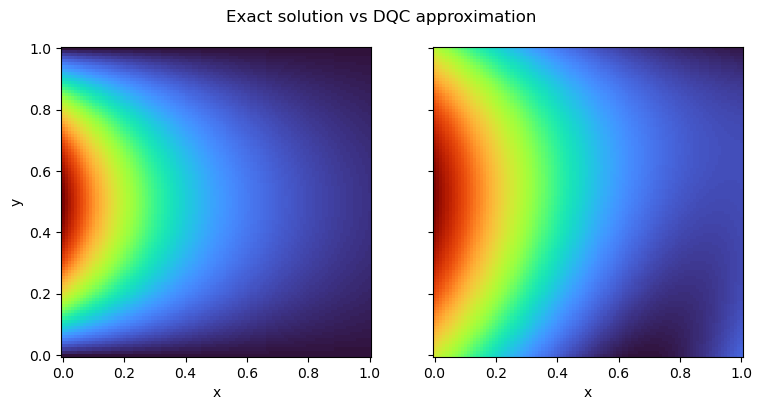

In [9]:
import matplotlib.pyplot as plt

n_points_1d = 100 
domain_1d = torch.linspace(0, 1.0, steps = n_points_1d)
domain = torch.tensor(list(product(domain_1d, domain_1d)))

# The exact solution for the Laplace equation
exp_x = torch.exp(-torch.pi * domain[:, 0])
sin_y = torch.sin(torch.pi * domain[:, 1])
exact_sol = (exp_x * sin_y).reshape(n_points_1d, n_points_1d).T
exact_sol = (exp_x * sin_y).reshape(n_points_1d, n_points_1d).T

dqc_sol = model_train(domain).reshape(n_points_1d, n_points_1d).T.detach()

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
fig.suptitle('Exact solution vs DQC approximation')

ax[0].pcolormesh(domain_1d,domain_1d.detach().numpy(), exact_sol, cmap='turbo')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_box_aspect(1)

cm = ax[1].pcolormesh(domain_1d,domain_1d.detach().numpy(), dqc_sol, cmap='turbo')
ax[1].set_xlabel('x')
ax[1].set_box_aspect(1)
#plt.colorbar(cm)

plt.tight_layout()
plt.savefig('pdesol_best_depth4.png')
plt.show()